In [143]:
using Plots
using ForwardDiff

In [144]:
function sample!(x,θ)
    T = size(θ,2)
    for t = 1:T-1
        x[t+1] = x[t] + ( rand() < θ[x[t] + T, t] ? 1 : -1 )
    end
end

sample! (generic function with 1 method)

In [201]:
function logqt(x,θ,t)
    return log((x[t+1] - x[t]) == 1 ? θ[x[t] + T] : 1 - θ[x[t] + T])
end

function logQ(x,θ)
    T = size(θ,2)
    s = 0
    for t = 1:T-1
        s += logqt(x,θ[:,t],t) 
    end
    return s
end

logQ (generic function with 1 method)

In [202]:
function gradient!(dθ, x, θ)
    T = size(θ,2)
    for t = 1:T-1
        ForwardDiff.gradient!(dθ[:,t], θt -> logqt(x,θt,t), θ[:,t])
    end
end

gradient! (generic function with 1 method)

In [203]:
T = 25 #total time of movement
N = 2T - 1

θ = fill(0.99,N,T); 
#This is an N x T matrix where θ[i,t] represents 
#the probability of jumping to right at time t for particle i
#The prob of jumping to left is 1-θ[i,t]
dθ = fill(1/2,N,T); 

θp = fill(1/2,N,T); 

x = zeros(Int,T);

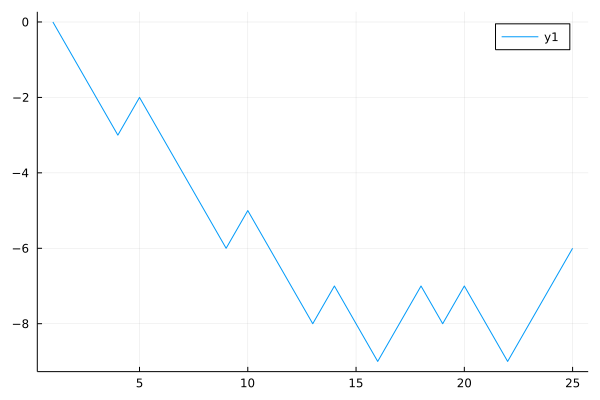

In [204]:
sample!(x,θp)
plot(x)

In [213]:
logQ(x,θp)

-16.635532333438686

In [214]:
log(1/2) * T

-17.328679513998633

In [205]:
gradient!(dθ, x, θ)
print(dθ)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5; 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5; 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5; 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5; 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5; 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5; 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5; 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5; 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5; 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.